In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np

import common

In [4]:
data_set_path = "../temp_sets_100/"

# Chartevents

## Read samples

In [5]:
chartevents_df = common.read_csv_no_rowid(data_set_path + "chartevents.csv")
chartevents_df = chartevents_df.sample(n=2000)

## Data preproces

In [6]:
# Drop useless colums
chartevents_df.drop(['subject_id', 'hadm_id', 'cgid', 'valuenum', 'valueuom', 'warning', 'error', 'resultstatus', 'stopped'], axis=1, inplace=True)

### Process null values

In [7]:
# Drop some null value
chartevents_df.dropna(subset=['icustay_id'], inplace=True, axis=0)

In [8]:
common.nan_count(chartevents_df)

Total columns: 5
Total rows: 2000
--------------
icustay_id     0
itemid         0
charttime      0
storetime     12
value         10
dtype: int64


In [9]:
chartevents_df['value'].fillna(value='Na', inplace=True)

### Set the column types

In [10]:
chartevents_df.dtypes

icustay_id    float64
itemid          int64
charttime      object
storetime      object
value          object
dtype: object

In [11]:
# Transfer some date type
# chartevents_df['subject_id'] = chartevents_df['subject_id'].astype(str)
# chartevents_df['hadm_id'] = chartevents_df['hadm_id'].astype(str)
# chartevents_df['icustay_id'] = chartevents_df['icustay_id'].astype(str)

# chartevents_df['itemid'] = chartevents_df['itemid'].astype(str)

chartevents_df['charttime'] = pd.to_datetime(chartevents_df['charttime'])
chartevents_df['storetime'] = pd.to_datetime(chartevents_df['storetime'])

In [12]:
chartevents_df.dtypes

icustay_id           float64
itemid                 int64
charttime     datetime64[ns]
storetime     datetime64[ns]
value                 object
dtype: object

### Process time value

In [13]:
icustays_df = common.read_csv_no_rowid(data_set_path+"icustays.csv")

In [14]:
icu_intime_df = icustays_df.loc[:, ['icustay_id', 'intime']]
icu_intime_df['intime'] = pd.to_datetime(icu_intime_df['intime'])

In [15]:
chartevents_mid_df = pd.merge(left=chartevents_df, right=icu_intime_df, how='left', on=['icustay_id'])

In [16]:
chartevents_mid_df.dtypes

icustay_id           float64
itemid                 int64
charttime     datetime64[ns]
storetime     datetime64[ns]
value                 object
intime        datetime64[ns]
dtype: object

In [17]:
chartevents_mid_df['storetime'] = chartevents_mid_df.apply(common.time_process, args=('charttime', 'storetime'), axis=1)
chartevents_mid_df['charttime'] = chartevents_mid_df.apply(common.time_process, args=('intime', 'charttime'), axis=1)

In [18]:
chartevents_mid_df

,icustay_id,itemid,charttime,storetime,value,intime
0,298740.0,3427,6011065.0,1800.0,Yes,2196-11-05 14:15:35
1,201090.0,166,280884.0,1440.0,Not Given,2139-04-16 12:58:36
2,292749.0,374,86084.0,600.0,PeriAnal,2183-03-10 03:05:16
3,211435.0,227566,949529.0,660.0,1000,2190-02-07 00:14:31
4,274351.0,159,31638.0,1380.0,None,2138-07-06 18:12:42
...,...,...,...,...,...,...
1995,252609.0,3327,695981.0,1560.0,Yes,2197-02-14 15:40:19
1996,203567.0,581,159776.0,3840.0,132.5,2146-04-23 23:37:04
1997,296844.0,211,3802140.0,4080.0,107,2131-06-05 15:51:00
1998,237618.0,742,111252.0,5880.0,1,2172-09-24 21:05:48


In [19]:
chartevents_df = chartevents_mid_df.drop(['icustay_id', 'intime'], axis=1)

In [20]:
chartevents_df.columns

Index(['itemid', 'charttime', 'storetime', 'value'], dtype='object')

---

##  Build Network

### Set constraints

In [21]:
from sdv.constraints import FixedCombinations

fixed_item_value_constraint = FixedCombinations(
    column_names=['itemid', 'value']
)

In [22]:
constraints = [fixed_item_value_constraint]

In [23]:
train_data = chartevents_df
best_model = common.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 2000/2000 [00:00<00:00, 46300.62it/s]


Gaussian Copula


Sampling rows: 100%|██████████| 2000/2000 [00:00<00:00, 54398.36it/s]


CTGAN


Sampling rows: 100%|██████████| 2000/2000 [00:00<00:00, 16628.56it/s]


CopulaGAN


Sampling rows: 100%|██████████| 2000/2000 [00:00<00:00, 22482.57it/s]


TVAE


Sampling rows: 100%|██████████| 2000/2000 [00:00<00:00, 28535.01it/s]


Training finished!
Strat evaluating ...
Evaluating finished!
CTGAN


Sampling rows: 100%|██████████| 2000/2000 [00:00<00:00, 22911.93it/s]


The ContinuousKL_score is: 0.9212193036206248
The DiscreteKL_score is: nan
The total score is: 0.6113760981933106


In [24]:
model_save_path = data_set_path + "100_models/" + "chartevents_model.pkl"
common.save_model(best_model, model_save_path)

---

## Evaluate data

### Generate synthetic data

In [25]:
# Load model
date_load_path = data_set_path + "100_models/" + "chartevents_model.pkl"
model = common.load_model(date_load_path)

In [26]:
sample = model.sample(num_rows=len(chartevents_df))

Sampling rows: 100%|██████████| 2000/2000 [00:00<00:00, 10924.33it/s]


### Post-process

In [27]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

In [28]:
def format_values(df):
    if is_number(df['value']):
        return round(float(df['value']), 2)
    else:
        return df['value']


In [29]:
sample['value'] = sample.apply(format_values, axis=1)
sample['value'] = sample['value'].astype(str)

### Evaluation

In [30]:
from sdv.evaluation import evaluate

In [31]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.9370304795443366

In [32]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

nan

In [33]:
evaluate(sample, train_data)

0.42752575353572386

<AxesSubplot:>

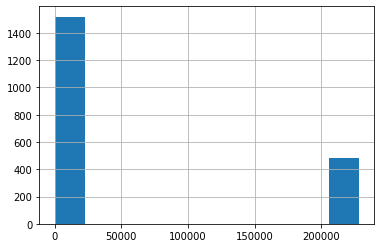

In [34]:
sample.sort_values('itemid')['itemid'].hist()

<AxesSubplot:>

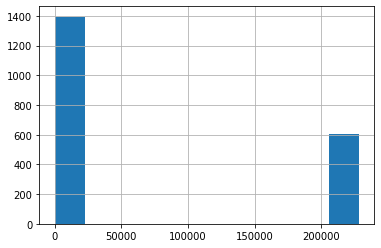

In [35]:
train_data.sort_values('itemid')['itemid'].hist()